In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from tabulate import tabulate


# For reproducibility 
torch.manual_seed(0)
np.random.seed(0)

In [2]:
class TeacherNet(nn.Module):
    def __init__(self):
        super(TeacherNet, self).__init__()
        self.layer1 = nn.Linear(100, 75, bias=True)
        self.layer2 = nn.Linear(75, 50, bias=True)
        self.layer3 = nn.Linear(50, 10, bias=True)
        self.layer_out = nn.Linear(10, 1, bias=True)
        
        # Initialize weights as N(0,1)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Weight init: N(0,1)
                m.weight.data.normal_(mean=0.0, std=1.0)
                # Bias init: N(0,1)
                m.bias.data.normal_(mean=0.0, std=1.0)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.layer_out(x) 
        return x

In [3]:
# Number of test examples
TEST_SIZE = 60_000

X_test = 2 * torch.rand(TEST_SIZE, 100)

# Instantiate the teacher network
teacher = TeacherNet()
teacher.eval() 

# Get teacher outputs
with torch.no_grad():
    y_test = teacher(X_test).squeeze()


In [4]:
def init_weights_normal(m):
    if isinstance(m, nn.Linear):
        m.weight.data.normal_(0.0, 1.0)
        m.bias.data.normal_(0.0, 1.0)

class StudentUnder(nn.Module):
    """Under-parameterized: 1 hidden layer (size 10)."""
    def __init__(self):
        super(StudentUnder, self).__init__()
        self.layer1 = nn.Linear(100, 10)
        self.layer_out = nn.Linear(10, 1)
        self.apply(init_weights_normal)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.layer_out(x)
        return x

class StudentEqual(nn.Module):
    """Same architecture as teacher: 3 hidden layers (75, 50, 10)."""
    def __init__(self):
        super(StudentEqual, self).__init__()
        self.layer1 = nn.Linear(100, 75)
        self.layer2 = nn.Linear(75, 50)
        self.layer3 = nn.Linear(50, 10)
        self.layer_out = nn.Linear(10, 1)
        self.apply(init_weights_normal)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.layer_out(x)
        return x

class StudentOver(nn.Module):
    """Over-parameterized: 4 hidden layers (200, 200, 200, 100)."""
    def __init__(self):
        super(StudentOver, self).__init__()
        self.layer1 = nn.Linear(100, 200)
        self.layer2 = nn.Linear(200, 200)
        self.layer3 = nn.Linear(200, 200)
        self.layer4 = nn.Linear(200, 100)
        self.layer_out = nn.Linear(100, 1)
        self.apply(init_weights_normal)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = self.layer_out(x)
        return x

In [5]:
def train_student(student_model, teacher_model, 
                  lr=1e-3, batch_size=128, 
                  num_iterations=3000, log_interval=200):
    """
    Train the 'student_model' to mimic 'teacher_model' via MSE loss.
    Returns lists of (train_losses, test_losses).
    """
    student_model.train()
    optimizer = optim.Adam(student_model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses = []
    test_losses = []

    for it in range(num_iterations):
        # 1) Sample fresh batch
        X_batch = 2 * torch.rand(batch_size, 100)
        with torch.no_grad():
            y_batch = teacher_model(X_batch).squeeze()

        # 2) Forward pass (student)
        y_pred = student_model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        
        # 3) Backward + update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Periodically evaluate on test set
        if (it+1) % log_interval == 0:
            student_model.eval()
            with torch.no_grad():
                y_test_pred = student_model(X_test).squeeze()
                test_loss = criterion(y_test_pred, y_test).item()
            train_losses.append(loss.item())
            test_losses.append(test_loss)
            student_model.train()

    return train_losses, test_losses

In [6]:
def train(lrs):

    # Hyperparameters
    num_iterations = 10000
    log_interval = 200
    BATCH_SIZE = 256

    best_test_loss_u = float('inf')
    best_test_loss_e = float('inf')
    best_test_loss_o = float('inf')
    best_lr_u = 0
    best_lr_e = 0
    best_lr_o = 0

    for lr in lrs:

        print(f"Learning rate: {lr}")
        
        # Instantiate students
        student_under = StudentUnder()
        student_equal = StudentEqual()
        student_over = StudentOver()

        # Train and track losses
        print("Training UNDER-PARAMETERIZED student...")
        train_under_losses, test_under_losses = train_student(
            student_under, teacher,
            lr=lr,
            batch_size=BATCH_SIZE,
            num_iterations=num_iterations,
            log_interval=log_interval
        )

        print("Training EQUAL-PARAMETERIZED student...")
        train_equal_losses, test_equal_losses = train_student(
            student_equal, teacher,
            lr=lr,
            batch_size=BATCH_SIZE,
            num_iterations=num_iterations,
            log_interval=log_interval
        )

        print("Training OVER-PARAMETERIZED student...")
        train_over_losses, test_over_losses = train_student(
            student_over, teacher,
            lr=lr,
            batch_size=BATCH_SIZE,
            num_iterations=num_iterations,
            log_interval=log_interval
        )

        # Final test MSE
        criterion = nn.MSELoss()
        student_under.eval(); student_equal.eval(); student_over.eval()
        with torch.no_grad():
            y_test_pred_under = student_under(X_test).squeeze()
            y_test_pred_equal = student_equal(X_test).squeeze()
            y_test_pred_over  = student_over(X_test).squeeze()

            final_test_loss_under = criterion(y_test_pred_under, y_test).item()
            final_test_loss_equal = criterion(y_test_pred_equal, y_test).item()
            final_test_loss_over  = criterion(y_test_pred_over, y_test).item()
        
        if final_test_loss_under < best_test_loss_u:
            best_test_loss_u = final_test_loss_under
            best_lr_u = lr
        if final_test_loss_equal < best_test_loss_e:
            best_test_loss_e = final_test_loss_equal
            best_lr_e = lr
        if final_test_loss_over < best_test_loss_o:
            best_test_loss_o = final_test_loss_over
            best_lr_o = lr

    print(f"\nFinal test losses:\n"
        f"Under-parameterized: {final_test_loss_under:.3f}\n"
        f"Equal-parameterized: {final_test_loss_equal:.3f}\n"
        f"Over-parameterized:  {final_test_loss_over:.3f}\n\n")
    
    print(f"Best learning rates:\n"
        f"Under-parameterized: {best_lr_u}\n"
        f"Equal-parameterized: {best_lr_e}\n"
        f"Over-parameterized:  {best_lr_o}\n\n")
    
    return best_lr_u, best_lr_e, best_lr_o

In [7]:
# Learning rates tuning
lrs = [1e-4, 3.5e-4, 5e-4, 9e-4]
lr_u, lr_e, lr_o = train(lrs)

Learning rate: 0.0001
Training UNDER-PARAMETERIZED student...
Training EQUAL-PARAMETERIZED student...
Training OVER-PARAMETERIZED student...
Learning rate: 0.00035
Training UNDER-PARAMETERIZED student...
Training EQUAL-PARAMETERIZED student...
Training OVER-PARAMETERIZED student...
Learning rate: 0.0005
Training UNDER-PARAMETERIZED student...
Training EQUAL-PARAMETERIZED student...
Training OVER-PARAMETERIZED student...
Learning rate: 0.0009
Training UNDER-PARAMETERIZED student...
Training EQUAL-PARAMETERIZED student...
Training OVER-PARAMETERIZED student...

Final test losses:
Under-parameterized: 19606.609
Equal-parameterized: 15947.360
Over-parameterized:  59768.379


Best learning rates:
Under-parameterized: 0.0009
Equal-parameterized: 0.0009
Over-parameterized:  0.0009




In [8]:
# Re - train with best learning rates for more iterations

# Instantiate students
student_under = StudentUnder()
student_equal = StudentEqual()
student_over = StudentOver()

num_iterations = 15000
log_interval = 50
BATCH_SIZE = 216

# Train and track losses
print("Training UNDER-PARAMETERIZED student...")
train_under_losses, test_under_losses = train_student(
    student_under, teacher,
    lr=lr_u,
    batch_size=BATCH_SIZE,
    num_iterations=num_iterations,
    log_interval=log_interval
)

print("Training EQUAL-PARAMETERIZED student...")
train_equal_losses, test_equal_losses = train_student(
    student_equal, teacher,
    lr=lr_e,
    batch_size=BATCH_SIZE,
    num_iterations=num_iterations,
    log_interval=log_interval
)


print("Training OVER-PARAMETERIZED student...")
train_over_losses, test_over_losses = train_student(
    student_over, teacher,
    lr=lr_o/10,
    batch_size=BATCH_SIZE,
    num_iterations=int(num_iterations*2),
    log_interval=log_interval
)

# Final test MSE
criterion = nn.MSELoss()
student_under.eval(); student_equal.eval(); student_over.eval()
with torch.no_grad():
    y_test_pred_under = student_under(X_test).squeeze()
    y_test_pred_equal = student_equal(X_test).squeeze()
    y_test_pred_over  = student_over(X_test).squeeze()

    final_test_loss_under = criterion(y_test_pred_under, y_test).item()
    final_test_loss_equal = criterion(y_test_pred_equal, y_test).item()
    final_test_loss_over  = criterion(y_test_pred_over, y_test).item()

# print(f"Final test losses:\n"
#       f"Under-parameterized: {final_test_loss_under:.3f}\n"
#       f"Equal-parameterized: {final_test_loss_equal:.3f}\n"
#       f"Over-parameterized:  {final_test_loss_over:.3f}")

Training UNDER-PARAMETERIZED student...
Training EQUAL-PARAMETERIZED student...
Training OVER-PARAMETERIZED student...


In [9]:
ge_table_rows = []
ge_table_rows.append(["Under",   f"{final_test_loss_under:.1f}"])
ge_table_rows.append(["Equal",   f"{final_test_loss_equal:.1f}"])
ge_table_rows.append(["Over",    f"{final_test_loss_over:.1f}"])

ge_headers = [
            "Model",
            "Generalisation Error"
]
        
# Print the table for this prefix

print(tabulate(ge_table_rows, headers=ge_headers, tablefmt="github"))

| Model   |   Generalisation Error |
|---------|------------------------|
| Under   |                19545.1 |
| Equal   |                14608.9 |
| Over    |                21877.8 |


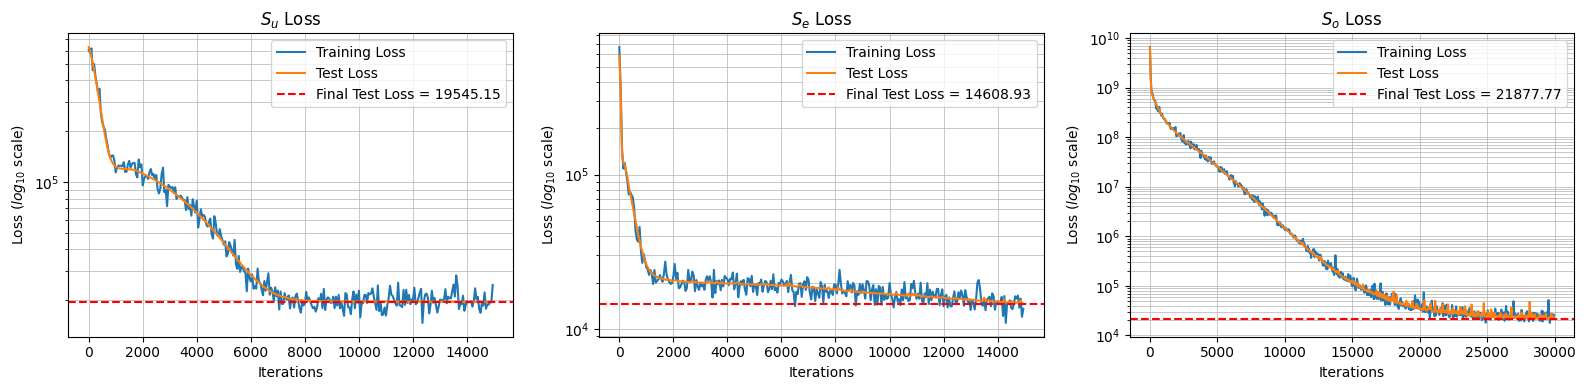

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
its_log = np.arange(1,num_iterations+1, log_interval)
its_log_o = np.arange(1,int(num_iterations*2)+1, log_interval)

# Left subplot: all pooled weights
axes[0].plot(its_log,train_under_losses,   label='Training Loss')
axes[0].plot(its_log, test_under_losses, label='Test Loss')
axes[0].axhline(y=test_under_losses[-1], color='r', linestyle='--', label=f'Final Test Loss = {final_test_loss_under:.2f}')
axes[0].set_title("$S_u$ Loss")
axes[0].legend()

# Right subplot: all pooled biases
axes[1].plot(its_log, train_equal_losses, label='Training Loss')
axes[1].plot(its_log, test_equal_losses, label='Test Loss')
axes[1].axhline(y=test_equal_losses[-1], color='r', linestyle='--', label=f'Final Test Loss = {final_test_loss_equal:.2f}')
axes[1].set_title("$S_e$ Loss")
axes[1].legend()

# Right subplot: all pooled biases
axes[2].plot(its_log_o, train_over_losses, label='Training Loss')
axes[2].plot(its_log_o, test_over_losses, label='Test Loss')
axes[2].axhline(y=final_test_loss_over, color='r', linestyle='--', label=f'Final Test Loss = {final_test_loss_over:.2f}')
axes[2].set_title("$S_o$ Loss")
axes[2].legend()

axes[0].set_xlabel(f'Iterations')
axes[0].set_ylabel('Loss ($log_{10}$ scale)')
axes[0].set_yscale('log')

axes[1].set_xlabel(f'Iterations')
axes[1].set_ylabel('Loss ($log_{10}$ scale)')
axes[1].set_yscale('log')

axes[2].set_xlabel(f'Iterations')
axes[2].set_ylabel('Loss ($log_{10}$ scale)')
axes[2].set_yscale('log')

axes[0].grid(True, which="both",ls="-", lw=0.5)
axes[1].grid(True, which="both", ls="-", lw=0.5)
axes[2].grid(True, which="both", ls="-", lw=0.5)

plt.tight_layout()
plt.savefig('losses.png')
plt.show()

In [14]:
def get_params_by_layer(model):
    """
    Return a dict mapping each layer's name
    to a numpy array of that layer's parameters
    (weights or biases).
    """
    param_dict = {}
    for name, param in model.named_parameters():
        # e.g., name == 'layer1.weight' or 'layer1.bias', etc.
        param_dict[name] = param.detach().flatten().cpu().numpy()
    return param_dict

# Get teacher params (layer-by-layer)
teacher_layer_dict = get_params_by_layer(teacher)

# Get each student's parameters (layer-by-layer)
under_layer_dict = get_params_by_layer(student_under)
equal_layer_dict = get_params_by_layer(student_equal)
over_layer_dict  = get_params_by_layer(student_over)

In [15]:
def plot_layers(
    teacher_dict,
    under_dict,
    equal_dict,
    over_dict,
    layer_prefixes=None,
    savename = None
):
    """
    Creates a 2-row, N-column figure (where N = len(layer_prefixes)):
      Row 0: weight distributions for each layer
      Row 1: bias distributions for each layer
    
    Each column corresponds to a particular layer prefix (e.g. "layer1", "layer2", ...).
    
    Colors are fixed for each network:
      - Teacher -> Blue
      - Under   -> Orange
      - Equal   -> Green
      - Over    -> Red
    """
    if layer_prefixes is None:
        layer_prefixes = ["layer1", "layer2", "layer3", "layer4", "layer_out"]
    
    # Define the colors for each model
    plot_colors = {
        "Teacher": "#1f77b4",  
        "Under":   "#ff7f0e",  
        "Equal":   "#2ca02c",  
        "Over":    "#d62728",
    }
    
    n_layers = len(layer_prefixes)
    
    fig, axes = plt.subplots(2, n_layers, figsize=(4*n_layers, 8))
    
    # Helper function to plot a single distribution
    def plot_dist(ax, data, label, color):
        if data is not None:
            n_points = len(data)
            if n_points > 1:
                n_bins = int(np.sqrt(n_points)+1)
                sns.histplot(data=data, ax=ax, label=label, color=color, fill=True, stat='density', bins=n_bins, alpha=0.6, kde=True)
            else:
                value = data[0]
                value_str = f"{value:.2f}"
                bin_width = 0.15
                bins = [value - bin_width / 2, value + bin_width / 2]
                sns.histplot(data=data, ax=ax, label=f"{label}={value_str}",
                            color=color, fill=True, stat='density', bins=bins)
    
    for col, prefix in enumerate(layer_prefixes):
        w_key = prefix + ".weight"
        b_key = prefix + ".bias"
        
        # --- top row => .weight
        if n_layers == 1:
            ax_w = axes[0]   # if there's only one column
        else:
            ax_w = axes[0, col]
        
        # gather data for the teacher / under / equal / over
        teacher_w = teacher_dict.get(w_key, None)
        under_w   = under_dict.get(w_key, None)
        equal_w   = equal_dict.get(w_key, None)
        over_w    = over_dict.get(w_key, None)
        
        # Plot each distribution
        plot_dist(ax_w, teacher_w, "Teacher", plot_colors["Teacher"])
        plot_dist(ax_w, under_w,   "Under",   plot_colors["Under"])
        plot_dist(ax_w, equal_w,   "Equal",   plot_colors["Equal"])
        plot_dist(ax_w, over_w,    "Over",    plot_colors["Over"])

        ax_w.set_title(f"{prefix}.weight")
        ax_w.legend()
        
        # --- bottom row => .bias
        if n_layers == 1:
            ax_b = axes[1]
        else:
            ax_b = axes[1, col]
        
        teacher_b = teacher_dict.get(b_key, None)
        under_b   = under_dict.get(b_key, None)
        equal_b   = equal_dict.get(b_key, None)
        over_b    = over_dict.get(b_key, None)
        
        plot_dist(ax_b, teacher_b, "Teacher", plot_colors["Teacher"])
        plot_dist(ax_b, under_b,   "Under",   plot_colors["Under"])
        plot_dist(ax_b, equal_b,   "Equal",   plot_colors["Equal"])
        plot_dist(ax_b, over_b,    "Over",    plot_colors["Over"])

        ax_b.set_title(f"{prefix}.bias")
        ax_b.legend()
    
    plt.tight_layout()

    if savename is not None:
        plt.savefig(savename)
        
    plt.show()

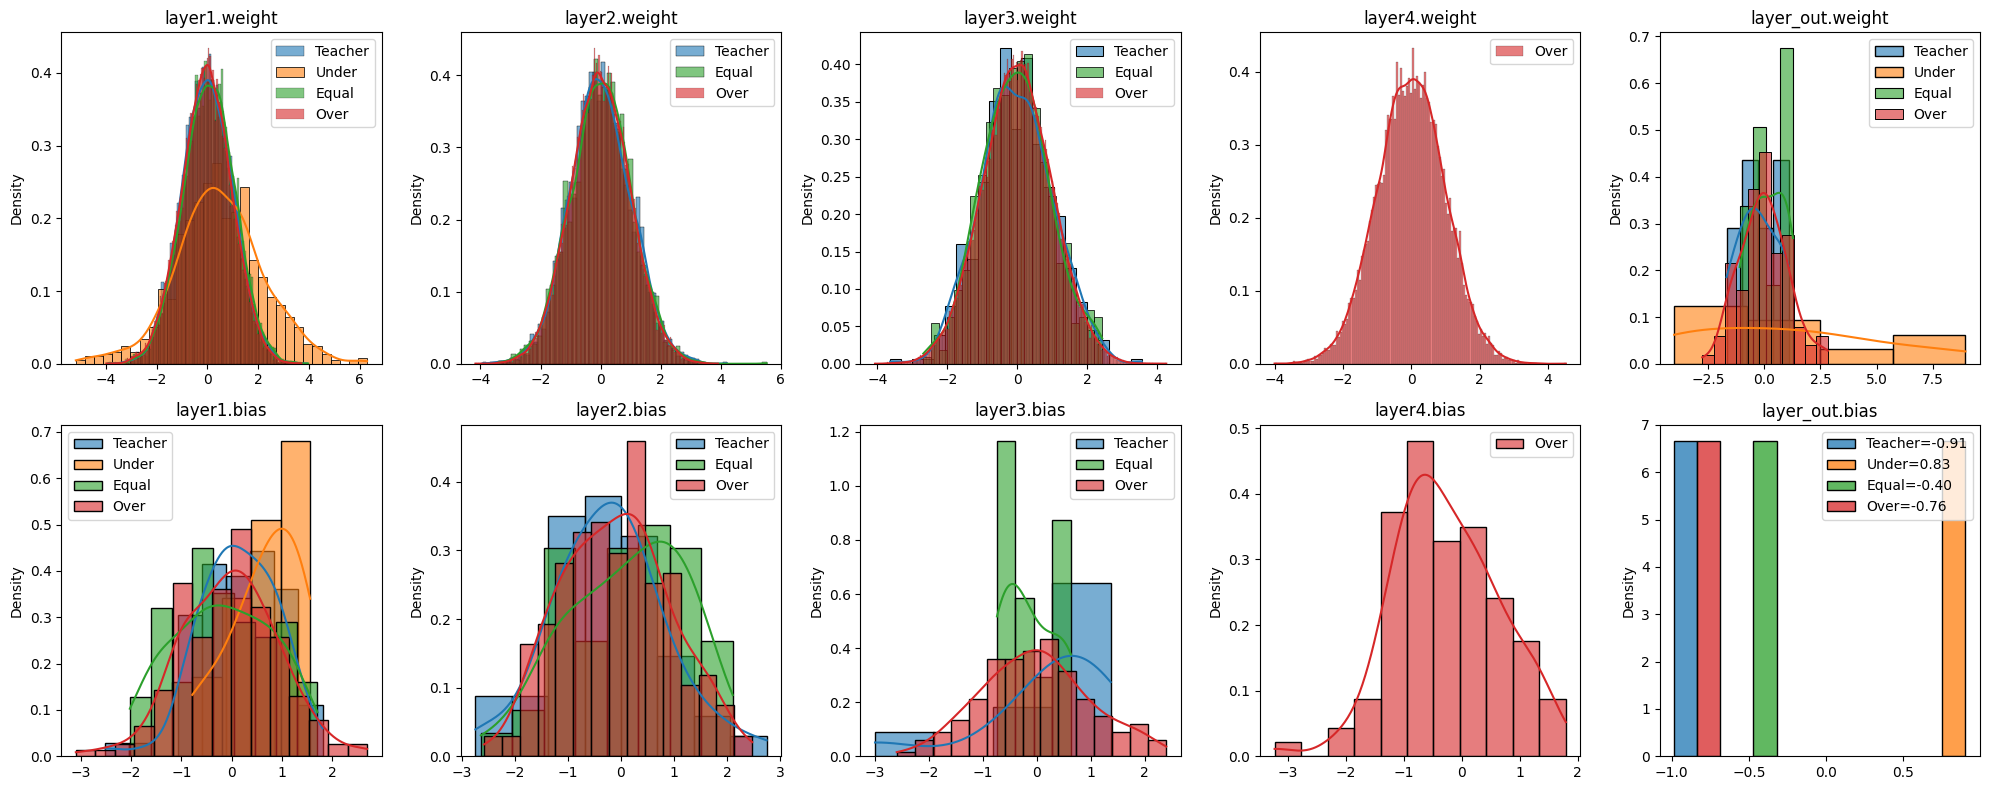

In [16]:
layer_prefixes = ["layer1", "layer2", "layer3", "layer4", "layer_out"]  # Example
plot_layers(
    teacher_layer_dict,
    under_layer_dict,
    equal_layer_dict,
    over_layer_dict,
    layer_prefixes=layer_prefixes,
    savename='layers_dist.png'
)

In [17]:
def summarize_params(param_array):
    """
    Returns (mean, std, min, max) as strings,
    or ("N/A", "N/A", "N/A", "N/A") if None or empty.
    """
    if param_array is None or len(param_array) == 0:
        return ("N/A", "N/A")
    return (
        f"{param_array.mean():.4f}",
        f"{param_array.std():.4f}",
    )

def build_stats_tables_by_layer(teacher_dict, under_dict, equal_dict, over_dict):
    """
    Creates one separate table per 'layer prefix', e.g.:
      * layer1
      * layer2
      * layer3
      * layer_out
      etc.
      
    For each layer, shows the stats for .weight and .bias
    across Teacher/Under/Equal/Over, if they exist.
    """
    # Collect all param keys
    all_keys = set(teacher_dict.keys()) \
             | set(under_dict.keys()) \
             | set(equal_dict.keys()) \
             | set(over_dict.keys())

    # A small helper to parse out (prefix, param_type) from "layer1.weight", etc.
    def parse_prefix_and_type(key):
        if key.endswith(".weight"):
            return key.replace(".weight", ""), "weight"
        elif key.endswith(".bias"):
            return key.replace(".bias", ""), "bias"
        else:
            # fallback if naming is different
            return key, "unknown"

    # Group keys by their prefix, e.g. "layer1", "layer2", ...
    layers_map = defaultdict(dict)
    for key in all_keys:
        prefix, ptype = parse_prefix_and_type(key)
        layers_map[prefix][ptype] = key

    # Now, for each prefix, we'll create a table containing
    # the rows: (Teacher, Under, Equal, Over)
    # and columns: param_type (weight/bias) + stats
    for prefix in sorted(layers_map.keys()):
        # gather the .weight key, .bias key if they exist
        weight_key = layers_map[prefix].get("weight", None)
        bias_key   = layers_map[prefix].get("bias",   None)

        # retrieve arrays from each dict
        teacher_w = teacher_dict.get(weight_key, None) if weight_key else None
        under_w   = under_dict.get(weight_key,   None) if weight_key else None
        equal_w   = equal_dict.get(weight_key,   None) if weight_key else None
        over_w    = over_dict.get(weight_key,    None) if weight_key else None

        teacher_b = teacher_dict.get(bias_key, None)   if bias_key else None
        under_b   = under_dict.get(bias_key,   None)   if bias_key else None
        equal_b   = equal_dict.get(bias_key,   None)   if bias_key else None
        over_b    = over_dict.get(bias_key,    None)   if bias_key else None

        # Summarize
        teacher_w_stats = summarize_params(teacher_w)
        under_w_stats   = summarize_params(under_w)
        equal_w_stats   = summarize_params(equal_w)
        over_w_stats    = summarize_params(over_w)

        teacher_b_stats = summarize_params(teacher_b)
        under_b_stats   = summarize_params(under_b)
        equal_b_stats   = summarize_params(equal_b)
        over_b_stats    = summarize_params(over_b)

        # Build table rows. We can do a row for each model * param_type.
        # Here, we'll do two param_types (weight, bias) per model row.
        # i.e., columns: [Model, w_mean, w_std, w_min, w_max, b_mean, b_std, b_min, b_max]
        # That’s just a matter of preference. Another approach is "model param_type" as separate rows.
        
        table_rows = []
        table_rows.append(["Teacher", *teacher_w_stats, *teacher_b_stats])
        table_rows.append(["Under",   *under_w_stats,   *under_b_stats])
        table_rows.append(["Equal",   *equal_w_stats,   *equal_b_stats])
        table_rows.append(["Over",    *over_w_stats,    *over_b_stats])

        headers = [
            "Model",
            "W_mean", "W_std",
            "B_mean", "B_std",
        ]
        
        # Print the table for this prefix
        print(f"=== Layer: {prefix} ===")
        print(tabulate(table_rows, headers=headers, tablefmt="github"))
        print()  # blank line

In [18]:
build_stats_tables_by_layer(
    teacher_layer_dict,
    under_layer_dict,
    equal_layer_dict,
    over_layer_dict
)

=== Layer: layer1 ===
| Model   |   W_mean |   W_std |   B_mean |   B_std |
|---------|----------|---------|----------|---------|
| Teacher |  -0.0018 |  0.9983 |   0.1461 |  0.7757 |
| Under   |   0.481  |  1.7356 |   0.6693 |  0.6997 |
| Equal   |   0.0655 |  1.007  |  -0.1616 |  0.9708 |
| Over    |  -0.0266 |  0.9918 |  -0.0311 |  0.9559 |

=== Layer: layer2 ===
| Model   | W_mean   | W_std   | B_mean   | B_std   |
|---------|----------|---------|----------|---------|
| Teacher | 0.0004   | 1.0168  | -0.2315  | 1.0629  |
| Under   | N/A      | N/A     | N/A      | N/A     |
| Equal   | 0.0113   | 1.0117  | 0.1190   | 1.0985  |
| Over    | -0.0060  | 0.9944  | -0.0970  | 1.0080  |

=== Layer: layer3 ===
| Model   | W_mean   | W_std   | B_mean   | B_std   |
|---------|----------|---------|----------|---------|
| Teacher | -0.0207  | 1.0260  | 0.1954   | 1.1909  |
| Under   | N/A      | N/A     | N/A      | N/A     |
| Equal   | -0.0388  | 0.9766  | -0.1243  | 0.4928  |
| Over    | -0

In [19]:
def get_weights_and_biases(model):
    """
    Return two 1D numpy arrays:
      - all_weights (concatenated from any '.weight' parameters)
      - all_biases  (concatenated from any '.bias'   parameters)
    """
    with torch.no_grad():
        weights_list = []
        biases_list  = []
        for name, param in model.named_parameters():
            if ".weight" in name:
                weights_list.append(param.view(-1))
            elif ".bias" in name:
                biases_list.append(param.view(-1))
        
        # Concatenate everything into 1D tensors
        all_weights = torch.cat(weights_list).cpu().numpy()
        all_biases  = torch.cat(biases_list).cpu().numpy()
        
    return all_weights, all_biases


# Example usage for your teacher/student models:
teacher_w, teacher_b = get_weights_and_biases(teacher)
under_w,   under_b   = get_weights_and_biases(student_under)
equal_w,   equal_b   = get_weights_and_biases(student_equal)
over_w,    over_b    = get_weights_and_biases(student_over)

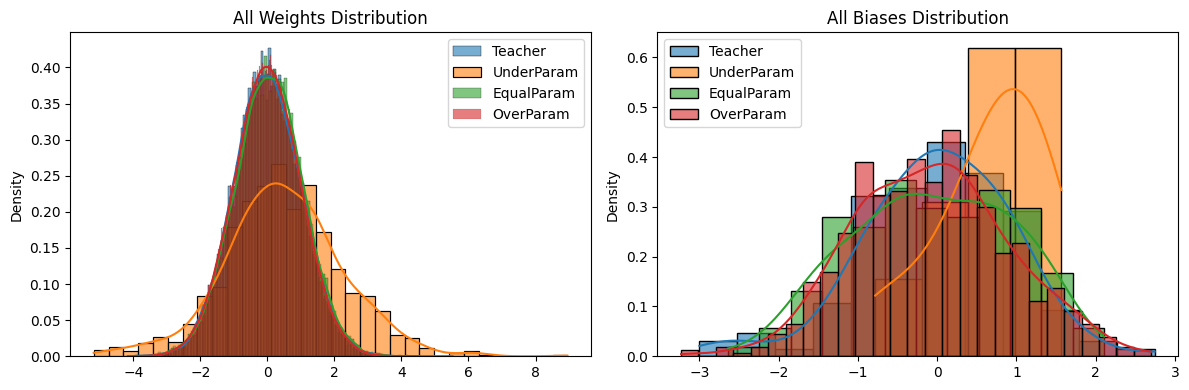

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

def n_bins_rule(n_points):
    return int(np.sqrt(n_points)+1)
plot_colors = {
        "Teacher": "#1f77b4",
        "Under":   "#ff7f0e",  
        "Equal":   "#2ca02c",  
        "Over":    "#d62728",  
}

# Left subplot: all pooled weights
sns.histplot(data=teacher_w, ax=axes[0], label='Teacher', color=plot_colors['Teacher'], fill=True, stat='density', bins=n_bins_rule(len(teacher_w)), alpha=0.6, kde=True)
sns.histplot(data=under_w, ax=axes[0], label='UnderParam', color=plot_colors['Under'], fill=True, stat='density', bins=n_bins_rule(len(under_w)), alpha=0.6, kde=True)
sns.histplot(data=equal_w, ax=axes[0], label='EqualParam', color=plot_colors['Equal'], fill=True, stat='density', bins=n_bins_rule(len(equal_w)), alpha=0.6, kde=True)
sns.histplot(data=over_w, ax=axes[0], label='OverParam', color=plot_colors['Over'], fill=True, stat='density', bins=n_bins_rule(len(over_w)), alpha=0.6, kde=True)
axes[0].set_title("All Weights Distribution")
axes[0].legend()

# Right subplot: all pooled biases

sns.histplot(data=teacher_b, ax=axes[1], label='Teacher', color=plot_colors['Teacher'], fill=True, stat='density', bins=n_bins_rule(len(teacher_b)), alpha=0.6, kde=True)
sns.histplot(data=under_b, ax=axes[1], label='UnderParam', color=plot_colors['Under'], fill=True, stat='density', bins=n_bins_rule(len(under_b)), alpha=0.6, kde=True)
sns.histplot(data=equal_b, ax=axes[1], label='EqualParam', color=plot_colors['Equal'], fill=True, stat='density', bins=n_bins_rule(len(equal_b)), alpha=0.6, kde=True)
sns.histplot(data=over_b, ax=axes[1], label='OverParam', color=plot_colors['Over'], fill=True, stat='density', bins=n_bins_rule(len(over_b)), alpha=0.6, kde=True)
axes[1].set_title("All Biases Distribution")
axes[1].legend()

plt.tight_layout()

plt.savefig('weights_biases_dist.png')
plt.show()

In [21]:
def tables_for_pooled(
    teacher_w, teacher_b,
    under_w,   under_b,
    equal_w,   equal_b,
    over_w,    over_b
):
    """
    Prints two separate tables:
      1) "All Weights" table
      2) "All Biases"  table
    showing (mean, std, min, max) for each model.
    """
    # -- Summarize for all weights --
    teacher_w_stats = summarize_params(teacher_w)
    under_w_stats   = summarize_params(under_w)
    equal_w_stats   = summarize_params(equal_w)
    over_w_stats    = summarize_params(over_w)

    # Build table for all weights
    table_weights = []
    table_weights.append(["Teacher", *teacher_w_stats])
    table_weights.append(["Under",   *under_w_stats])
    table_weights.append(["Equal",   *equal_w_stats])
    table_weights.append(["Over",    *over_w_stats])

    headers = ["Model", "Mean", "Std", "Min", "Max"]
    print("=== All Weights ===")
    print(tabulate(table_weights, headers=headers, tablefmt="github"))
    print()  # blank line

    # -- Summarize for all biases --
    teacher_b_stats = summarize_params(teacher_b)
    under_b_stats   = summarize_params(under_b)
    equal_b_stats   = summarize_params(equal_b)
    over_b_stats    = summarize_params(over_b)

    # Build table for all biases
    table_biases = []
    table_biases.append(["Teacher", *teacher_b_stats])
    table_biases.append(["Under",   *under_b_stats])
    table_biases.append(["Equal",   *equal_b_stats])
    table_biases.append(["Over",    *over_b_stats])

    print("=== All Biases ===")
    print(tabulate(table_biases, headers=headers, tablefmt="github"))
    print()

In [22]:
tables_for_pooled(
    teacher_w, teacher_b,
    under_w,   under_b,
    equal_w,   equal_b,
    over_w,    over_b
)

=== All Weights ===
| Model   |    Mean |    Std |
|---------|---------|--------|
| Teacher | -0.0021 | 1.0054 |
| Under   |  0.4859 | 1.7757 |
| Equal   |  0.0439 | 1.0075 |
| Over    | -0.0085 | 0.9959 |

=== All Biases ===
| Model   |    Mean |    Std |
|---------|---------|--------|
| Teacher |  0.0032 | 0.9444 |
| Under   |  0.6836 | 0.6686 |
| Equal   | -0.0574 | 0.9999 |
| Over    | -0.0816 | 0.9754 |

